# <span style="color: darkblue;">**Customer Segmentation - RFM Analysis**</span>

This project aims to analyze transactional data from an online UK-based retail store, covering customer purchases made between December 2010 and December 2011. Our primary goal is to segment customers using **Recency, Frequency, and Monetary (RFM) analysis**, allowing us to better understand customer loyalty and spending patterns.  

### **Key Steps in This Analysis:**  

1. **[Data Preprocessing](#section1)**: *Loading transactional data into an SQLite database for efficient querying and analysis.*  
2. **[RFM Analysis](#section2)**: *Calculating and assigning RFM scores to segment customers based on their purchasing behavior and overall value.*  
3. **[Insights & Recommendations](#section3)**: *Deriving actionable strategies from segment performance to optimize retention, reactivation, and revenue growth.*

<a id="section1"></a>
## <span style="color: #0D47A1;">**Data Preprocessing**</span>

---

In [1]:
# Library for importing database
import pandas as pd
import sqlite3

# Library for visualisation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
from IPython.display import Image, display

In [2]:
# Load the cleaned dataset
df = pd.read_csv("online_retail_cleaned.csv")  

# Connect to SQLite database
conn = sqlite3.connect("online_retail.db")

# Load DataFrame to SQL (automatically creates the table)
df.to_sql("online_retail", conn, if_exists="replace", index=False, dtype={
    "invoice_no": "TEXT",
    "stock_code": "TEXT",
    "description": "TEXT",
    "quantity": "INTEGER",
    "invoice_date": "TEXT",
    "invoice_time": "TEXT",
    "unit_price": "DECIMAL(10,2)",
    "customer_id": "TEXT",
    "country": "TEXT",
    "total_sales": "DECIMAL(10,2)"
})

391153

In [3]:
# Load SQL extension for Jupyter Notebook
%load_ext sql

# Connect to the SQLite database
%sql sqlite:///online_retail.db

# Removing the display limit
%config SqlMagic.displaylimit = 0

Connecting to 'sqlite:///online_retail.db'

In [4]:
%%sql
PRAGMA table_info(online_retail);

Running query in 'sqlite:///online_retail.db'

+-----+--------------+---------------+---------+------------+----+
| cid |     name     |      type     | notnull | dflt_value | pk |
+-----+--------------+---------------+---------+------------+----+
|  0  |  invoice_no  |      TEXT     |    0    |    None    | 0  |
|  1  |  stock_code  |      TEXT     |    0    |    None    | 0  |
|  2  | description  |      TEXT     |    0    |    None    | 0  |
|  3  |   quantity   |    INTEGER    |    0    |    None    | 0  |
|  4  | invoice_date |      TEXT     |    0    |    None    | 0  |
|  5  |  unit_price  | DECIMAL(10,2) |    0    |    None    | 0  |
|  6  | customer_id  |      TEXT     |    0    |    None    | 0  |
|  7  |   country    |      TEXT     |    0    |    None    | 0  |
|  8  | invoice_time |      TEXT     |    0    |    None    | 0  |
|  9  | total_sales  | DECIMAL(10,2) |    0    |    None    | 0  |
+-----+--------------+---------------+---------+------------+----+

In [5]:
%%sql
SELECT * FROM online_retail LIMIT 5;

Running query in 'sqlite:///online_retail.db'

+------------+------------+-------------------------------------+----------+--------------+------------+-------------+----------------+--------------+-------------+
| invoice_no | stock_code |             description             | quantity | invoice_date | unit_price | customer_id |    country     | invoice_time | total_sales |
+------------+------------+-------------------------------------+----------+--------------+------------+-------------+----------------+--------------+-------------+
|   536365   |   85123A   |  WHITE HANGING HEART T-LIGHT HOLDER |    6     |  2010-12-01  |    2.55    |    17850    | United Kingdom |   08:26:00   |     15.3    |
|   536365   |   71053    |         WHITE METAL LANTERN         |    6     |  2010-12-01  |    3.39    |    17850    | United Kingdom |   08:26:00   |    20.34    |
|   536365   |   84406B   |    CREAM CUPID HEARTS COAT HANGER   |    8     |  2010-12-01  |    2.75    |    17850    | United Kingdom |   08:26:00   |      22     |
|   536365   |   84029G   | KNITTED UNION FLAG HOT WATER BOTTLE |    6     |  2010-12-01  |    3.39    |    17850    | United Kingdom |   08:26:00   |    20.34    |
|   536365   |   84029E   |    RED WOOLLY HOTTIE WHITE HEART    |    6     |  2010-12-01  |    3.39    |    17850    | United Kingdom |   08:26:00   |    20.34    |
+------------+------------+-------------------------------------+----------+--------------+------------+-------------+----------------+--------------+-------------+

<a id="section2"></a>
## <span style="color: #0D47A1;">**RFM Analysis**</span>

---
| **RFM Component** | **What it Measures**            | **Why It Is Important**                                                                                           |
|------------------|--------------------------------|----------------------------------------------------------------------------------------------------------------------|
| **Recency (R)**   | Days since the last purchase    | Helps identify how recently a customer has interacted with the business, indicating their current level of engagement. |
| **Frequency (F)** | Number of purchases              | Reveals how often a customer makes purchases, reflecting their loyalty and long-term relationship with the brand.       |
| **Monetary (M)**  | Total money spent                | Shows how much revenue a customer generates, helping identify high-value and profitable customers.                      |

---

### 1. Calculating RFM Scores

#### Calculating Recency (R)
We will identify each customer's most recent transaction and calculate the number of days since their last purchase. 

In [6]:
%%sql
SELECT MAX(invoice_date) AS last_order_date
FROM online_retail;

Running query in 'sqlite:///online_retail.db'

+-----------------+
| last_order_date |
+-----------------+
|    2011-12-09   |
+-----------------+

> Using *'2011-12-09'* (the most recent date in the dataset) as the reference point, we will analyze transactions recorded between '2010-12-01' and '2011-12-09'.

In [7]:
%%sql
SELECT customer_id,
       MAX(invoice_date) AS last_purchase_date,
       (julianday('2011-12-09') - julianday(MAX(invoice_date))) AS recency
FROM online_retail
GROUP BY customer_id
LIMIT 10;

Running query in 'sqlite:///online_retail.db'

+-------------+--------------------+---------+
| customer_id | last_purchase_date | recency |
+-------------+--------------------+---------+
|    12346    |     2011-01-18     |  325.0  |
|    12347    |     2011-12-07     |   2.0   |
|    12348    |     2011-09-25     |   75.0  |
|    12349    |     2011-11-21     |   18.0  |
|    12350    |     2011-02-02     |  310.0  |
|    12352    |     2011-11-03     |   36.0  |
|    12353    |     2011-05-19     |  204.0  |
|    12354    |     2011-04-21     |  232.0  |
|    12355    |     2011-05-09     |  214.0  |
|    12356    |     2011-11-17     |   22.0  |
+-------------+--------------------+---------+

#### Calculating Frequency (F)
Counting how many unique transactions each customer made.

In [8]:
%%sql
SELECT customer_id,
       COUNT(DISTINCT invoice_no) AS frequency
FROM online_retail
GROUP BY customer_id
LIMIT 10;

Running query in 'sqlite:///online_retail.db'

+-------------+-----------+
| customer_id | frequency |
+-------------+-----------+
|    12346    |     1     |
|    12347    |     7     |
|    12348    |     4     |
|    12349    |     1     |
|    12350    |     1     |
|    12352    |     7     |
|    12353    |     1     |
|    12354    |     1     |
|    12355    |     1     |
|    12356    |     3     |
+-------------+-----------+

#### Calculating Monetary (M)
Suming total spending per customer.

In [9]:
%%sql
SELECT customer_id,
       ROUND(SUM(total_sales), 2) AS monetary
FROM online_retail
GROUP BY customer_id
LIMIT 10;

Running query in 'sqlite:///online_retail.db'

+-------------+----------+
| customer_id | monetary |
+-------------+----------+
|    12346    | 77183.6  |
|    12347    |  4310.0  |
|    12348    | 1437.24  |
|    12349    | 1457.55  |
|    12350    |  294.4   |
|    12352    | 1385.74  |
|    12353    |   89.0   |
|    12354    |  1079.4  |
|    12355    |  459.4   |
|    12356    | 2487.43  |
+-------------+----------+

#### Calculating Average RFM Values

In [10]:
%%sql
WITH rfm AS (
    SELECT 
       o.customer_id,
       (julianday('2011-12-09') - julianday(MAX(o.invoice_date))) AS recency,
       COUNT(DISTINCT o.invoice_no) AS frequency,
       ROUND(SUM(o.total_sales), 2) AS monetary
    FROM online_retail o
    GROUP BY o.customer_id
)
SELECT 
    ROUND(AVG(recency), 2) AS avg_recency,
    ROUND(AVG(frequency), 2) AS avg_frequency,
    ROUND(AVG(monetary), 2) AS avg_monetary
FROM rfm;

Running query in 'sqlite:///online_retail.db'

+-------------+---------------+--------------+
| avg_recency | avg_frequency | avg_monetary |
+-------------+---------------+--------------+
|    92.23    |      4.25     |   2015.97    |
+-------------+---------------+--------------+

> The average values across all customers are:
> - **Recency**: 92.23 days → On average, customers haven't purchased in over 3 months.
> - **Frequency**: 4.25 orders → Most customers have made around 4 purchases in the observed period.
> - **Monetary**: £2,015.97 → On average, each customer has spent over £2,000, indicating a relatively high customer value.

#### Assigning RFM Scores 
Each RFM metric (Recency, Frequency, Monetary) is scored on a scale of 1 to 5 based on its performance and value, with higher scores indicating better customer engagement and spending behavior.

In [11]:
%%sql
CREATE VIEW rfm_analysis AS
WITH rfm AS (
    SELECT 
       o.customer_id,
       (julianday('2011-12-09') - julianday(MAX(o.invoice_date))) AS recency,
       COUNT(DISTINCT o.invoice_no) AS frequency,
       ROUND(SUM(o.total_sales), 2) AS monetary
    FROM online_retail o
    GROUP BY o.customer_id
)
SELECT 
    customer_id,
    recency,
    frequency,
    monetary,
    -- R-Score => Lower recency = better => ORDER BY recency DESC
    NTILE(5) OVER (ORDER BY recency DESC) AS r_score,
    -- F-Score => Higher frequency = better => ORDER BY frequency ASC
    NTILE(5) OVER (ORDER BY frequency) AS f_score,
    -- M-Score => Higher spending = better => ORDER BY monetary ASC
    NTILE(5) OVER (ORDER BY monetary) AS m_score
FROM rfm;

Running query in 'sqlite:///online_retail.db'

++
||
++
++

In [12]:
%%sql
SELECT * FROM rfm_analysis
LIMIT 10;

Running query in 'sqlite:///online_retail.db'

+-------------+---------+-----------+----------+---------+---------+---------+
| customer_id | recency | frequency | monetary | r_score | f_score | m_score |
+-------------+---------+-----------+----------+---------+---------+---------+
|    13747    |  373.0  |     1     |   79.6   |    1    |    1    |    1    |
|    17643    |  373.0  |     1     |  101.55  |    1    |    1    |    1    |
|    18011    |  373.0  |     1     |  102.79  |    1    |    1    |    1    |
|    15350    |  373.0  |     1     |  115.65  |    1    |    1    |    1    |
|    14237    |  373.0  |     1     |  161.0   |    1    |    1    |    1    |
|    12791    |  373.0  |     1     |  177.6   |    1    |    1    |    1    |
|    13065    |  373.0  |     1     |  205.86  |    1    |    1    |    1    |
|    17908    |  373.0  |     1     |  232.03  |    1    |    1    |    1    |
|    16583    |  373.0  |     1     |  233.45  |    1    |    1    |    1    |
|    17968    |  373.0  |     1     |  265.1   |    1    |    1    |    2    |
+-------------+---------+-----------+----------+---------+---------+---------+

### Distribution of Recency, Frequency, and Monetary Metrics Across Customers

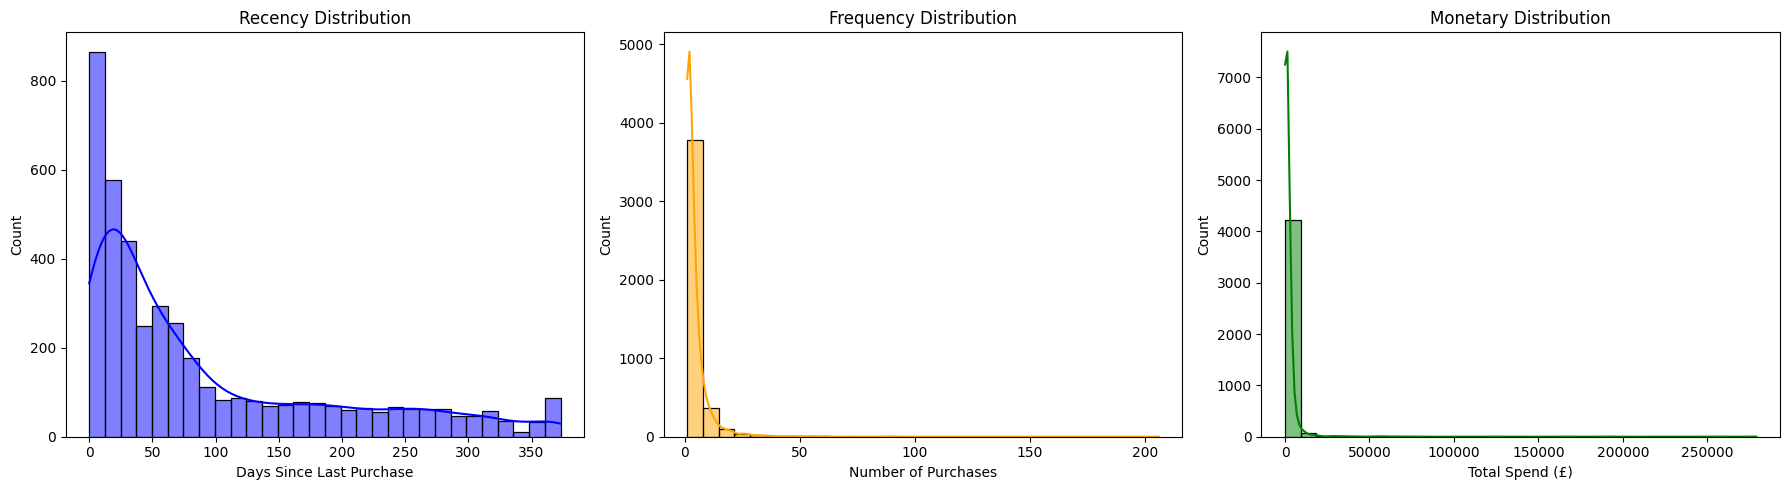

In [13]:
query = """
SELECT customer_id, recency, frequency, monetary
FROM rfm_analysis;
"""
df_rfm = pd.read_sql(query, conn)

# Plotting the histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_rfm['recency'], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Days Since Last Purchase")

sns.histplot(df_rfm['frequency'], bins=30, kde=True, ax=axes[1], color="orange")
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Number of Purchases")

sns.histplot(df_rfm['monetary'], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Total Spend (£)")

plt.tight_layout()
plt.show()

> The histograms display how customers are distributed across recency (days since last purchase), frequency (number of purchases), and monetary value (total spend in £). The histograms show:
> - **Recency** is **heavily right-skewed**, with most customers not purchasing recently, suggesting potential inactivity or churn.
> - **Frequency** shows that a majority of customers placed **fewer than 5 orders**, with a steep drop-off beyond that.
> - **Monetary** has a **long-tailed distribution**, where most customers spend under £5,000, but a small elite group contributes significantly more, with some spending over £10,000.

> These plots confirm a **Pareto pattern** — a small portion of customers drives the bulk of business value, highlighting the need for targeted retention and loyalty strategies.

### 2. Assigning Customer Segments

This table categorizes customers based on their recency (R), frequency (F), and monetary (M) scores, providing insights into their engagement levels and suggesting appropriate marketing actions.

---
| S. No | **Customer Segment**       | Description                                                                 | Marketing Action & Recommendations | **R Score** | **(F+M)/2 Score** |  
|------|----------------------------|---------------------------------------------------------------------------|----------------------------------|------------|-----------------|  
| 1    | <span style="color:#339AF0;">**Champions**</span>             | Most loyal and valuable customers who frequently purchase and engage with your brand. | Introduce new and upcoming products and drops. Reward them and help them share updates. Provide priority access and loyalty perks. | 5          | 4 - 5        |  
| 2    | <span style="color:#DA77F2;">**Potential Loyalists**</span>   | Customers with growing interest and engagement, indicating potential loyalty. | Offer membership/loyalty programs, recommend other products, nurture with personalized offers and incentives. | 4 - 5      | 2 - 3        |  
| 3    | <span style="color:#91A7FF;">**Loyal Customers**</span>       | Regular customers who consistently engage with and purchase from your brand. | Upsell higher-value products, ask for reviews, maintain engagement with personalized communication and loyalty programs. | 3 - 4      | 4 - 5        |  
| 4    | <span style="color:#0CA678;">**New Customers**</span>      | First-time buyers who recently started engaging with your brand. | Provide onboarding support, give them early success, start building a relationship with welcome emails and special offers. | 5          | 1            |  
| 5    | <span style="color:#38D9A9;">**Promising**</span>             | New or occasional customers with good potential based on recent behavior. | Encourage further engagement with special offers, tailored content, or invitations to loyalty programs. Check on their need for replenishment. | 4          | 1            |  
| 6    | <span style="color:#FFA8A8;">**Needs Attention**</span>       | Customers with decent engagement but show early signs of decreasing interest or activity. | Make limited-time offers, recommend products based on past purchases, re-engage with personalized outreach. | 3          | 3            |  
| 7    | <span style="color:#FAB005;">**About to Sleep**</span>        | Customers who have purchased before but have shown declining engagement or inactivity. | Send personalized re-engagement campaigns, offer discounts or reminders about their previous activity. Introduce them to new products. | 3          | 1 - 2        |  
| 8    | <span style="color:#E03131;">**Can't Lose Them**</span>       | High-value customers with recent inactivity or signs of disengagement. | Provide VIP treatment, personalized outreach, exclusive offers, and reconnect with high-value incentives. | 1 - 2      | 5            |  
| 9    | <span style="color:#F76707;">**At Risk**</span>               | Customers with reduced frequency of purchase or engagement, indicating potential churn. | Send personalized emails to reconnect, offer renewals, provide helpful resources, and recommend popular products. | 1 - 2      | 3 - 4        |  
| 10   | <span style="color:#757575;">**Hibernating**</span>           | Customers who were once active but have not engaged in a significant period. | Offer other relevant products and special discounts. Recreate brand value and reactivate through targeted campaigns. | 1 - 2      | 1 - 2        |

---

In [14]:
%%sql
CREATE VIEW customer_segments AS
SELECT customer_id,
       ROUND((r_score + f_score + m_score) / 3.0, 1) AS avg_rfm,
       (r_score * 100 + f_score * 10 + m_score) AS rfm_score,
       CASE
           WHEN r_score = 5 AND (f_score + m_score) / 2 BETWEEN 4 AND 5 THEN 'Champions'
           WHEN r_score BETWEEN 3 AND 4 AND (f_score + m_score) / 2 BETWEEN 4 AND 5 THEN 'Loyal Customers'
           WHEN r_score BETWEEN 4 AND 5 AND (f_score + m_score) / 2 BETWEEN 2 AND 3 THEN 'Potential Loyalists'
           WHEN r_score = 5 AND (f_score + m_score) / 2 = 1 THEN 'New Customers'
           WHEN r_score = 4 AND (f_score + m_score) / 2 = 1 THEN 'Promising'
           WHEN r_score = 3 AND (f_score + m_score) / 2 = 3 THEN 'Needs Attention'
           WHEN r_score = 3 AND (f_score + m_score) / 2 BETWEEN 1 AND 2 THEN 'About to Sleep'
           WHEN r_score BETWEEN 1 AND 2 AND (f_score + m_score) / 2 = 5 THEN 'Can’t Lose Them'
           WHEN r_score BETWEEN 1 AND 2 AND (f_score + m_score) / 2 BETWEEN 3 AND 4 THEN 'At Risk'
           WHEN r_score BETWEEN 1 AND 2 AND (f_score + m_score) / 2 BETWEEN 1 AND 2 THEN 'Hibernating'
           ELSE 'Others'
       END AS customer_segment
FROM (
    SELECT
        customer_id, r_score, f_score, m_score
    FROM rfm_analysis
) AS sub;

Running query in 'sqlite:///online_retail.db'

++
||
++
++

In [15]:
%%sql
SELECT * FROM customer_segments   
LIMIT 10;

Running query in 'sqlite:///online_retail.db'

+-------------+---------+-----------+------------------+
| customer_id | avg_rfm | rfm_score | customer_segment |
+-------------+---------+-----------+------------------+
|    13747    |   1.0   |    111    |   Hibernating    |
|    17643    |   1.0   |    111    |   Hibernating    |
|    18011    |   1.0   |    111    |   Hibernating    |
|    15350    |   1.0   |    111    |   Hibernating    |
|    14237    |   1.0   |    111    |   Hibernating    |
|    12791    |   1.0   |    111    |   Hibernating    |
|    13065    |   1.0   |    111    |   Hibernating    |
|    17908    |   1.0   |    111    |   Hibernating    |
|    16583    |   1.0   |    111    |   Hibernating    |
|    17968    |   1.3   |    112    |   Hibernating    |
+-------------+---------+-----------+------------------+

### Customer Segments vs. RFM Score Distribution

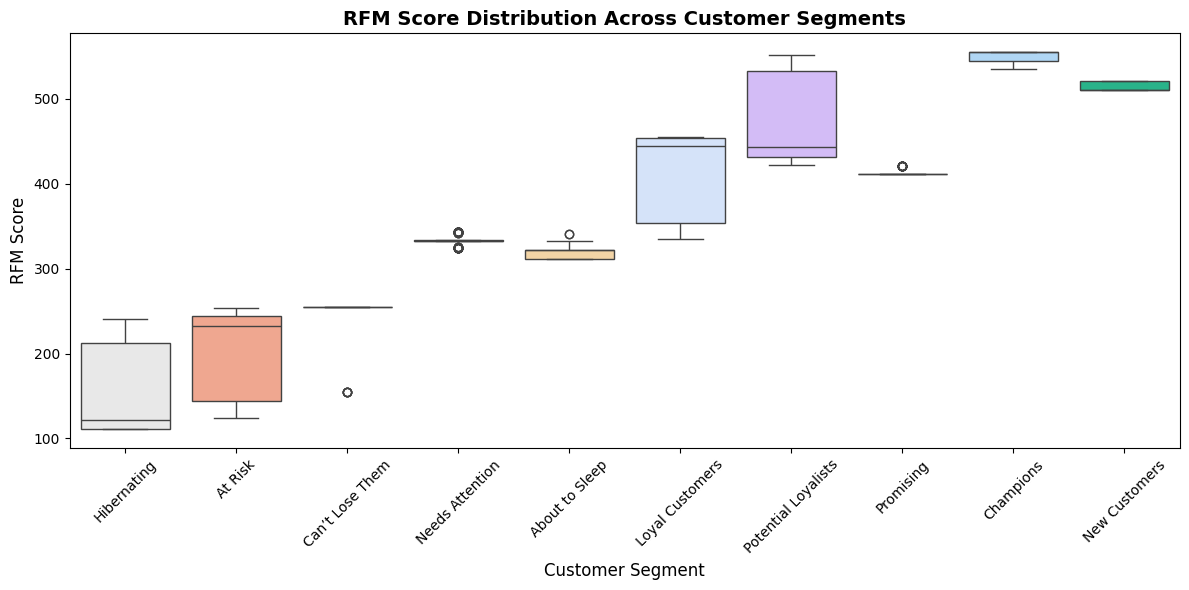

In [16]:
query = "SELECT customer_segment, rfm_score FROM customer_segments;"
df_rfm = pd.read_sql(query, conn)

# Assigning colors to customer segments
segment_colors = {
    "Champions": "#A5D8FF",
    "Loyal Customers": "#CFE2FF",
    "Potential Loyalists": "#D1B3FF",  
    "Needs Attention": "#FFCAB1",
    "About to Sleep": "#FFD699",
    "Promising": "#A8E6CF",  
    "New Customers": "#12ca93",
    "At Risk": "#FF9F80",
    "Can’t Lose Them": "#FF7F7F",
    "Hibernating": "#E8E8E8"}
unique_segments = df_rfm['customer_segment'].unique()
segment_palette = {seg: segment_colors.get(seg, '#D3D3D3') for seg in unique_segments}

#Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="customer_segment", y="rfm_score", hue="customer_segment", data=df_rfm, palette=segment_palette, legend=False)
plt.xticks(rotation=45)
plt.xlabel("Customer Segment", fontsize=12)
plt.ylabel("RFM Score", fontsize=12)
plt.title("RFM Score Distribution Across Customer Segments", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

> *This boxplot shows the spread of RFM scores across each customer segment, highlighting median behavior and variability within segments. Segments with higher median scores are typically more valuable or engaged customers.*

### Customer Segment Analysis  
Detailed analysis of customer segments by calculating key metrics for each segment.

In [17]:
%%sql
SELECT 
    seg.customer_segment, 
    COUNT(rfm.customer_id) AS total_customers,
    ROUND(SUM(rfm.monetary), 2) AS total_revenue,
    ROUND(SUM(rfm.monetary) / SUM(rfm.frequency), 2) AS avg_order_value, 
    ROUND(AVG(rfm.recency), 2) AS avg_recency,   
    ROUND(AVG(rfm.frequency), 2) AS avg_frequency, 
    ROUND(AVG(rfm.monetary), 2) AS avg_monetary 
FROM customer_segments seg
JOIN rfm_analysis rfm ON seg.customer_id = rfm.customer_id
GROUP BY seg.customer_segment
ORDER BY total_revenue DESC;

Running query in 'sqlite:///online_retail.db'

+---------------------+-----------------+---------------+-----------------+-------------+---------------+--------------+
|   customer_segment  | total_customers | total_revenue | avg_order_value | avg_recency | avg_frequency | avg_monetary |
+---------------------+-----------------+---------------+-----------------+-------------+---------------+--------------+
|      Champions      |       589       |   4464307.62  |      585.25     |     5.31    |     12.95     |   7579.47    |
|   Loyal Customers   |       723       |   2295466.0   |      474.27     |     33.1    |      6.69     |   3174.92    |
|       At Risk       |       565       |   864166.33   |      512.25     |    148.88   |      2.99     |    1529.5    |
| Potential Loyalists |       535       |   334992.12   |      252.82     |    15.78    |      2.48     |    626.15    |
|     Hibernating     |       1138      |   321868.83   |      228.93     |    214.06   |      1.24     |    282.84    |
|   Needs Attention   |       205       |   180064.45   |      349.64     |    51.23    |      2.51     |    878.36    |
|   Can’t Lose Them   |        31       |   133140.42   |      443.8      |    133.87   |      9.68     |   4294.85    |
|    About to Sleep   |       371       |   113223.12   |      231.07     |    50.73    |      1.32     |    305.18    |
|      Promising      |       119       |    19824.69   |      144.71     |     22.0    |      1.15     |    166.59    |
|    New Customers    |        58       |    10174.06   |      137.49     |     6.95    |      1.28     |    175.41    |
+---------------------+-----------------+---------------+-----------------+-------------+---------------+--------------+

- **Champions** (589 customers) generate over **£4.46M**, nearly half of all revenue, with an AOV of £585 and ~13 orders each.
- **Loyal Customers** (723 customers) contribute **£2.29M**, showing strong recurring behavior and healthy AOV.
- **At Risk** and **Can’t Lose Them** customers, while fewer, still generate high value, highlighting them as recovery priorities.
- **Hibernating** and **About to Sleep** are larger in size but contribute significantly less, indicating disengagement.
- **New Customers** and **Promising** are small and low-value, but represent opportunity if nurtured early.

### Comparative Heatmaps of Customer Segments by RFM Metrics

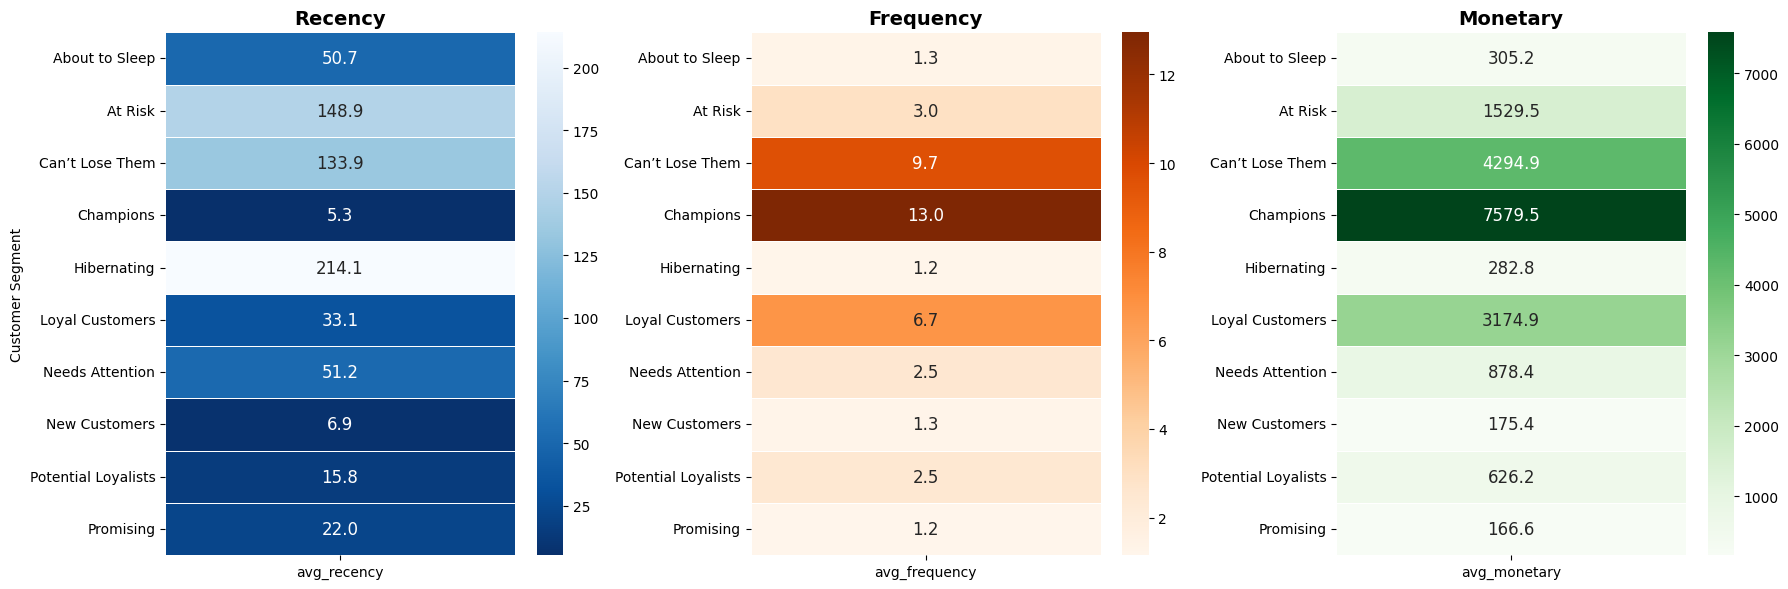

In [18]:
# Fetch RFM averages by segment
query = """
    SELECT seg.customer_segment, 
           AVG(rfm.recency) AS avg_recency, 
           AVG(rfm.frequency) AS avg_frequency, 
           AVG(rfm.monetary) AS avg_monetary
    FROM rfm_analysis rfm
    JOIN customer_segments seg ON rfm.customer_id = seg.customer_id
    GROUP BY seg.customer_segment;
"""
df_rfm_heatmap = pd.read_sql(query, conn)
df_rfm_heatmap.set_index("customer_segment", inplace=True)   # Set 'customer_segment' as index for heatmap

# Define individual color maps
colormaps = {
    "avg_recency": "Blues_r",  # Lower Recency is better
    "avg_frequency": "Oranges",  # Higher Frequency is better
    "avg_monetary": "Greens"   # Higher Monetary is better
}

# Creating 3 heatmaps side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (column, cmap) in enumerate(colormaps.items()):
    sns.heatmap(df_rfm_heatmap[[column]], annot=True, fmt=".1f", cmap=cmap, linewidths=0.5, ax=axes[i], annot_kws={"size": 12})
    axes[i].set_title(column.replace("avg_", "").capitalize(), fontsize=14, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Customer Segment" if i == 0 else "")
plt.tight_layout()
plt.show()

These side-by-side heatmaps compare average **Recency**, **Frequency**, and **Monetary** across customer segments:
- **Champions** have the best scores across all three dimensions (lowest recency, highest frequency and monetary).
- **Hibernating** and **At Risk** segments stand out with high recency (inactive), but differ in value and frequency.
- **Can’t Lose Them** also show low recency with high monetary value — a clear recovery opportunity.
- The visual layout clearly communicates where engagement and spending are strongest or slipping.

### Customer Distribution by Recency and Frequency + Monetary Scores

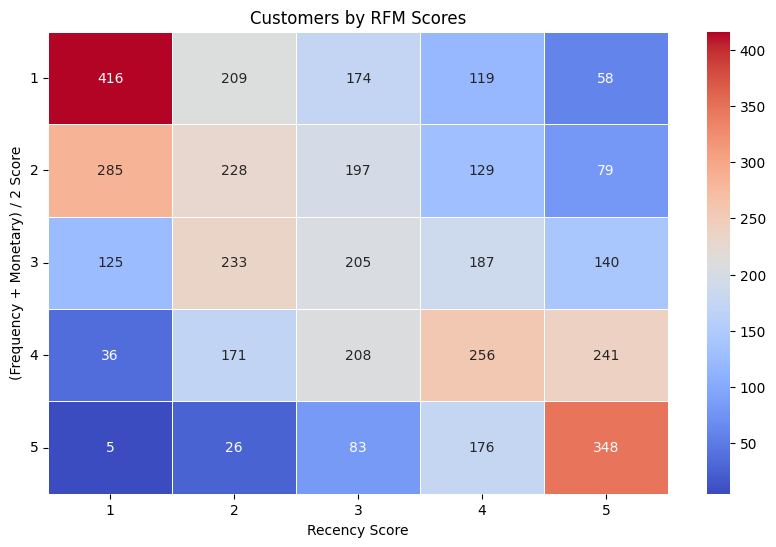

In [19]:
# Fetch R & F Scores with Customer Count
query = """
    SELECT r_score, (f_score + m_score) / 2 AS avg_fm_score, COUNT(customer_id) AS total_customers
    FROM rfm_analysis
    GROUP BY r_score, avg_fm_score;
"""
df_grid = pd.read_sql(query, conn)

# Pivot the table for heatmap format
heatmap_data = df_grid.pivot(index="avg_fm_score", columns="r_score", values="total_customers")

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm", linewidths=0.5, cbar=True)
plt.xlabel("Recency Score")
plt.ylabel("(Frequency + Monetary) / 2 Score")
plt.title("Customers by RFM Scores")
plt.xticks(rotation=0)  # Ensure the labels are readable
plt.yticks(rotation=0)
plt.show()

This heatmap shows the **concentration of customers** across a matrix of **Recency** and **(Frequency + Monetary)/2** scores:
- The densest cluster lies in mid-to-low R scores (i.e., older last purchases), with moderate FM scores — indicating many customers are at risk or dormant.
- Few customers have low recency and high FM scores — aligning with the “Champion” profile. This grid helps visually assess which scoring combinations contain the largest customer bases and where to target marketing efforts.

### RFM Segmentation Map: Customer Segments by Recency and Frequency/Monetary

In [20]:
# Fetch RFM segment data
query = """
    SELECT cs.customer_segment, 
           ra.r_score, 
           (ra.f_score + ra.m_score) / 2 AS avg_fm_score, 
           COUNT(cs.customer_id) AS customer_count
    FROM customer_segments cs
    JOIN rfm_analysis ra ON cs.customer_id = ra.customer_id
    GROUP BY cs.customer_segment, ra.r_score, avg_fm_score
    ORDER BY avg_fm_score DESC, ra.r_score;
"""
df_mosaic = pd.read_sql(query, conn)

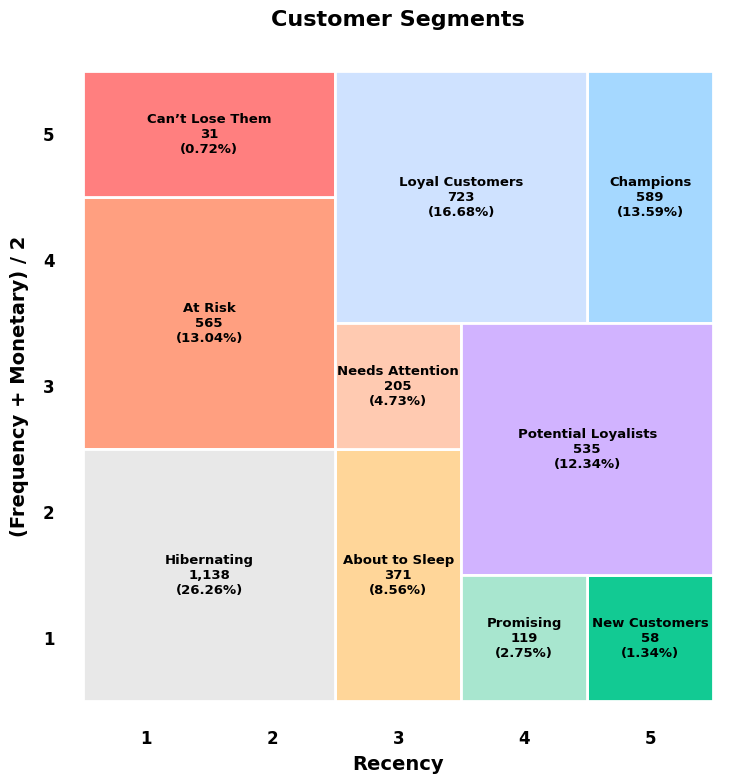

In [21]:
# Calculate total customers
total_customers = df_mosaic['customer_count'].sum()

# Group by segment, recency, and average frequency+monetary score
pivot_data = df_mosaic.groupby(["customer_segment", "r_score", "avg_fm_score"])["customer_count"].sum().reset_index()

# Plot figure
fig, ax = plt.subplots(figsize=(16.5, 9), facecolor="white")
ax.set_aspect(0.5)
for spine in ax.spines.values():
    spine.set_visible(False)

# Prepare merged blocks for each segment
merged_blocks = []
for segment in pivot_data["customer_segment"].unique():
    segment_data = pivot_data[pivot_data["customer_segment"] == segment]

    min_r = segment_data["r_score"].min()
    max_r = segment_data["r_score"].max()
    min_fm = segment_data["avg_fm_score"].min()
    max_fm = segment_data["avg_fm_score"].max()

    total_segment_customers = segment_data["customer_count"].sum()
    percentage = round((total_segment_customers / total_customers) * 100, 2)

    merged_blocks.append({
        "segment": segment,
        "r_start": min_r - 1,
        "r_width": max_r - min_r + 1,
        "fm_start": min_fm - 1,
        "fm_height": max_fm - min_fm + 1,
        "customer_count": total_segment_customers,
        "percentage": percentage
    })

# Draw the merged rectangles and label them
for block in merged_blocks:
    rect = Rectangle((block["r_start"], block["fm_start"]), block["r_width"], block["fm_height"], 
                     facecolor=segment_colors.get(block["segment"], "#D3D3D3"), edgecolor="white", linewidth=2)
    ax.add_patch(rect)
    ax.text(block["r_start"] + block["r_width"] / 2, block["fm_start"] + block["fm_height"] / 2,
            f"{block['segment']}\n{block['customer_count']:,}\n({block['percentage']}%)",
            ha="center", va="center", fontsize=9.5, fontweight="bold", color="black")
tick_positions = np.arange(5) + 0.5
ax.set_xticks(tick_positions)
ax.set_xticklabels(range(1, 6), fontsize=12, color="black", fontweight="bold")
ax.set_yticks(tick_positions)
ax.set_yticklabels(range(1, 6), fontsize=12, color="black", fontweight="bold")
ax.tick_params(axis='both', which='both', length=0, pad=-2)
label_fontsize = 14
ax.set_xlabel("Recency", fontsize=label_fontsize, fontweight="bold", color="black", labelpad=5)  
ax.set_ylabel("(Frequency + Monetary) / 2", fontsize=label_fontsize, fontweight="bold", color="black", labelpad=10)  
plt.title("Customer Segments", fontsize=16, fontweight="bold", color="black", pad=10)
plt.grid(False)
plt.axis("scaled")
plt.show()

> This shows how customers are distributed based on their RFM scores. Each rectangle corresponds to a customer segment (e.g., Champions, Potential Loyalists). Labels inside each rectangle show segment name, count, and percentage of total customer. 
> - **Champions** and **Loyal Customers** dominate the top-right of the grid — high FM scores and low recency, signaling active, high-value buyers.
> - Segments like **At Risk** and **Hibernating** fall toward lower FM and higher recency, indicating disengagement and potential churn.
> - Mid-tier segments like **Promising** and **Needs Attention** occupy narrow score bands, suggesting more targeted growth or retention potential.

### Revenue Analysis by Customer Segment
Revenue Distribution and Trends by Customer Segment

In [22]:
# Revenue over time by segment 
query_revenue_overtime = """
    SELECT 
        strftime('%Y-%m', o.invoice_date) AS month,
        seg.customer_segment,
        ROUND(SUM(o.total_sales), 2) AS total_revenue
    FROM customer_segments seg
    JOIN online_retail o ON seg.customer_id = o.customer_id
    GROUP BY month, seg.customer_segment
    ORDER BY month ASC, total_revenue DESC;
"""
df_revenue_overtime = pd.read_sql(query_revenue_overtime, conn)
df_revenue_overtime

month     customer_segment  total_revenue
0    2010-12            Champions      300768.69
1    2010-12      Loyal Customers      130305.68
2    2010-12              At Risk       58917.99
3    2010-12          Hibernating       34572.07
4    2010-12      Can’t Lose Them       20125.96
..       ...                  ...            ...
106  2011-11            Promising       17990.36
107  2011-11        New Customers        4316.93
108  2011-12            Champions      466897.93
109  2011-12  Potential Loyalists       40591.74
110  2011-12        New Customers        4738.41

[111 rows x 3 columns]

In [23]:
# Revenue contribution by segment 
query_revenue_cont = """
    SELECT seg.customer_segment,
           ROUND(SUM(o.total_sales), 2) AS total_revenue
    FROM customer_segments seg
    JOIN online_retail o ON seg.customer_id = o.customer_id
    GROUP BY seg.customer_segment
    ORDER BY total_revenue DESC;
"""
df_revenue_cont = pd.read_sql(query_revenue_cont, conn)
df_revenue_cont

customer_segment  total_revenue
0            Champions     4464307.62
1      Loyal Customers     2295466.00
2              At Risk      864166.33
3  Potential Loyalists      334992.12
4          Hibernating      321868.83
5      Needs Attention      180064.45
6      Can’t Lose Them      133140.42
7       About to Sleep      113223.12
8            Promising       19824.69
9        New Customers       10174.06

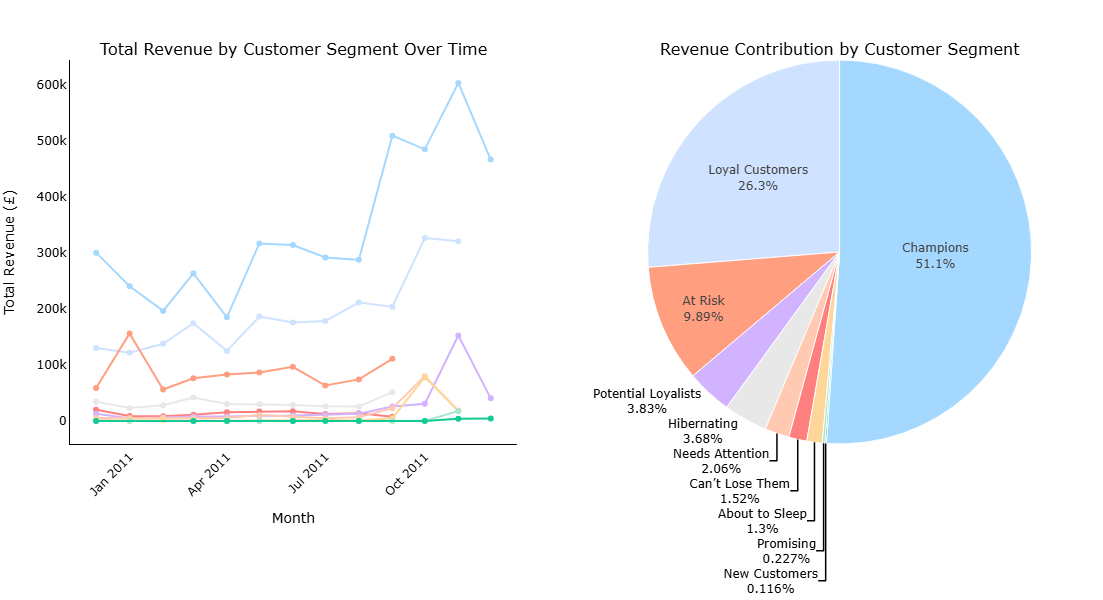

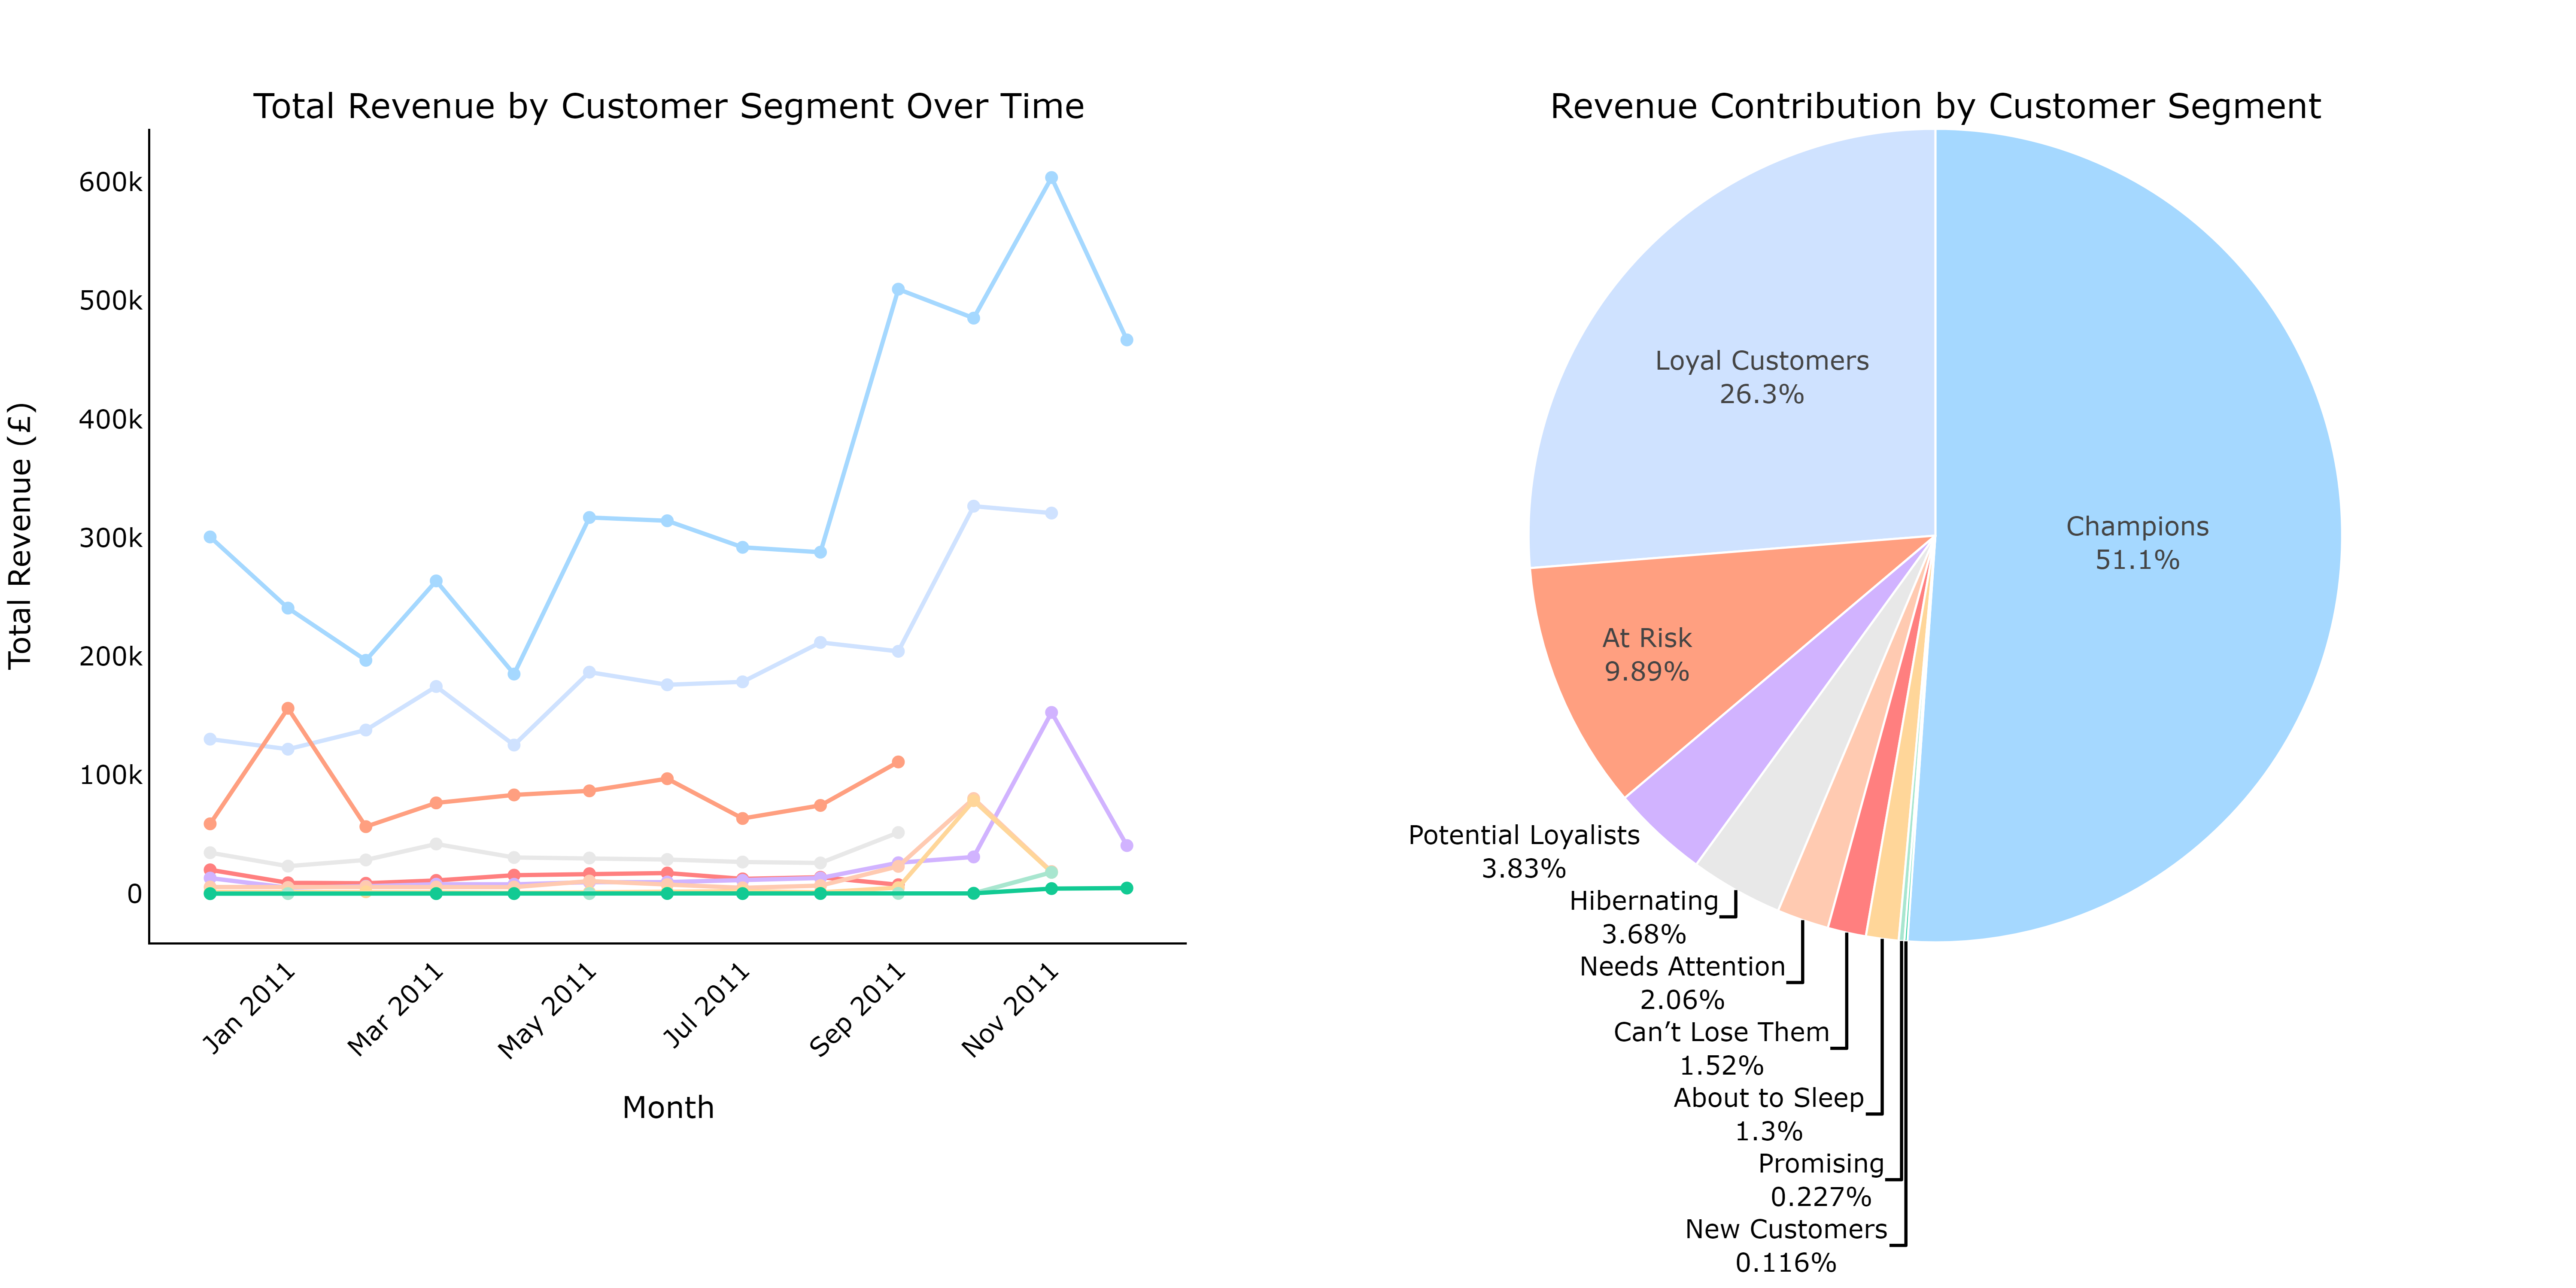

In [24]:
# Consistent color palette for both charts
segment_palette_line = [segment_colors.get(seg, "#D3D3D3") for seg in df_revenue_cont["customer_segment"]]
color_dict = {seg: segment_colors.get(seg, "#D3D3D3") for seg in df_revenue_cont["customer_segment"]}

# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Total Revenue by Customer Segment Over Time", "Revenue Contribution by Customer Segment"),
                    specs=[[{"type": "scatter"}, {"type": "domain"}]])

# Line Chart 
for segment in df_revenue_overtime['customer_segment'].unique():
    data = df_revenue_overtime[df_revenue_overtime['customer_segment'] == segment]
    fig.add_trace(
     go.Scatter(x=data['month'], y=data['total_revenue'], mode='lines+markers', name=segment, line=dict(color=segment_colors.get(segment, "#D3D3D3")),
            hovertemplate=f"<b>{segment}</b><br>Month: %{{x}}<br>Revenue: £%{{y:,.2f}}<extra></extra>", showlegend=False), row=1, col=1)

# Pie Chart 
fig.add_trace(
    go.Pie(labels=df_revenue_cont['customer_segment'], values=df_revenue_cont['total_revenue'],
           marker=dict(colors=[segment_colors.get(seg, "#D3D3D3") for seg in df_revenue_cont['customer_segment']], line=dict(color='white', width=1)),
           textinfo='label+percent', hovertemplate="<b>%{label}</b><br>Revenue: £%{value:,.2f}<br>Percent: %{percent}<extra></extra>",
           showlegend=False), row=1, col=2)

# Final layout
fig.update_layout(height=600, width=1200, margin=dict(t=60, b=40, l=40, r=40), plot_bgcolor='white', paper_bgcolor='white', 
                  xaxis=dict(title="Month", showgrid=False, showline=True, linecolor='black', tickangle=-45, 
                             tickfont=dict(color='black'), titlefont=dict(color='black')),
                  yaxis=dict(title="Total Revenue (£)", showgrid=False, showline=True, linecolor='black', 
                             tickfont=dict(color='black'), titlefont=dict(color='black')), font=dict(color='black'))
fig.show()

# Save as standalone HTML
pyo.plot(fig, filename="revenue_by_segments.html", auto_open=False)

# Save static image of the figure
pio.write_image(fig, "revenue_by_segments.png", format="png", scale=5)
display(Image(filename="revenue_by_segments.png"))

> This dual visualization combines **temporal trends and segment-level revenue distribution** uncovering not only who drives the most revenue but **when**:  
> - The **line chart** shows monthly revenue trends by segment. **Champions and Loyal Customers** dominate revenue generation, with clear spikes during peak shopping seasons (e.g., October–November holiday period)
> - The **pie chart** shows overall revenue contribution share by segment. **Champions alone contribute over 50% of total revenue**, followed by Loyal Customers and At Risk segments — collectively making up the bulk of financial performance.<br><br/>

### Customer Segments Distribution by Recency and Frequency Scores

In [25]:
# Fetch customer segmentation data with sales & order frequency
query = """
    SELECT 
    c.customer_segment, 
    AVG(r.recency) AS avg_recency,
    AVG(r.frequency) AS avg_frequency,
    AVG(r.monetary) AS avg_monetary,
    COUNT(c.customer_id) AS total_customers
FROM customer_segments c
JOIN rfm_analysis r ON c.customer_id = r.customer_id
GROUP BY c.customer_segment;
"""
df_order_segment = pd.read_sql(query, conn)

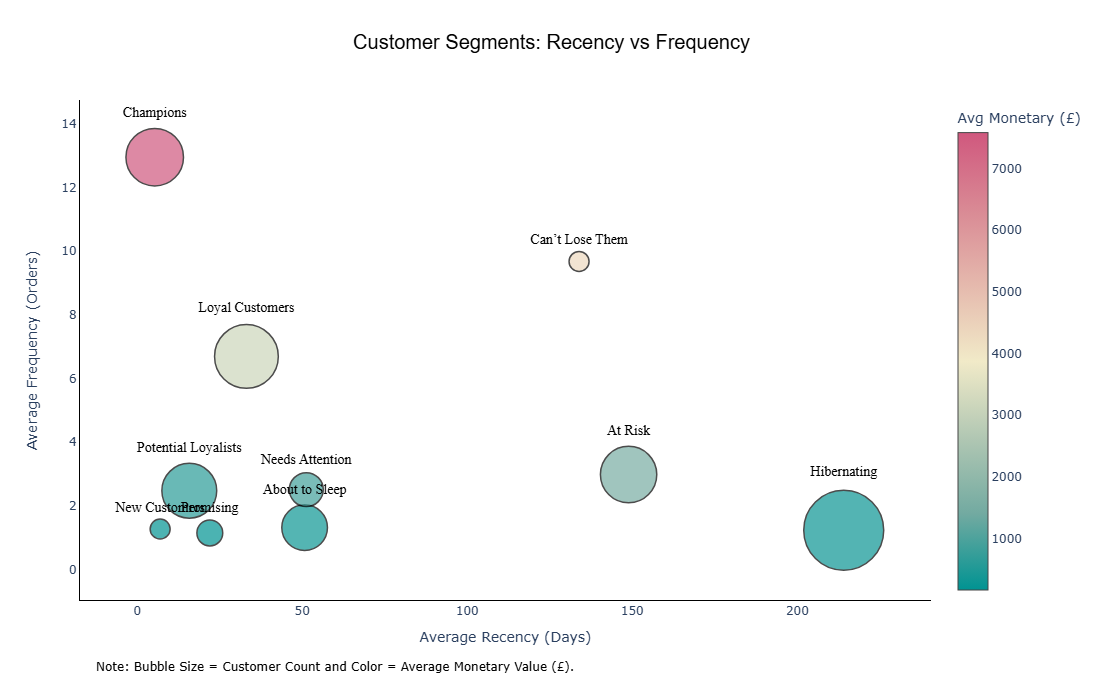

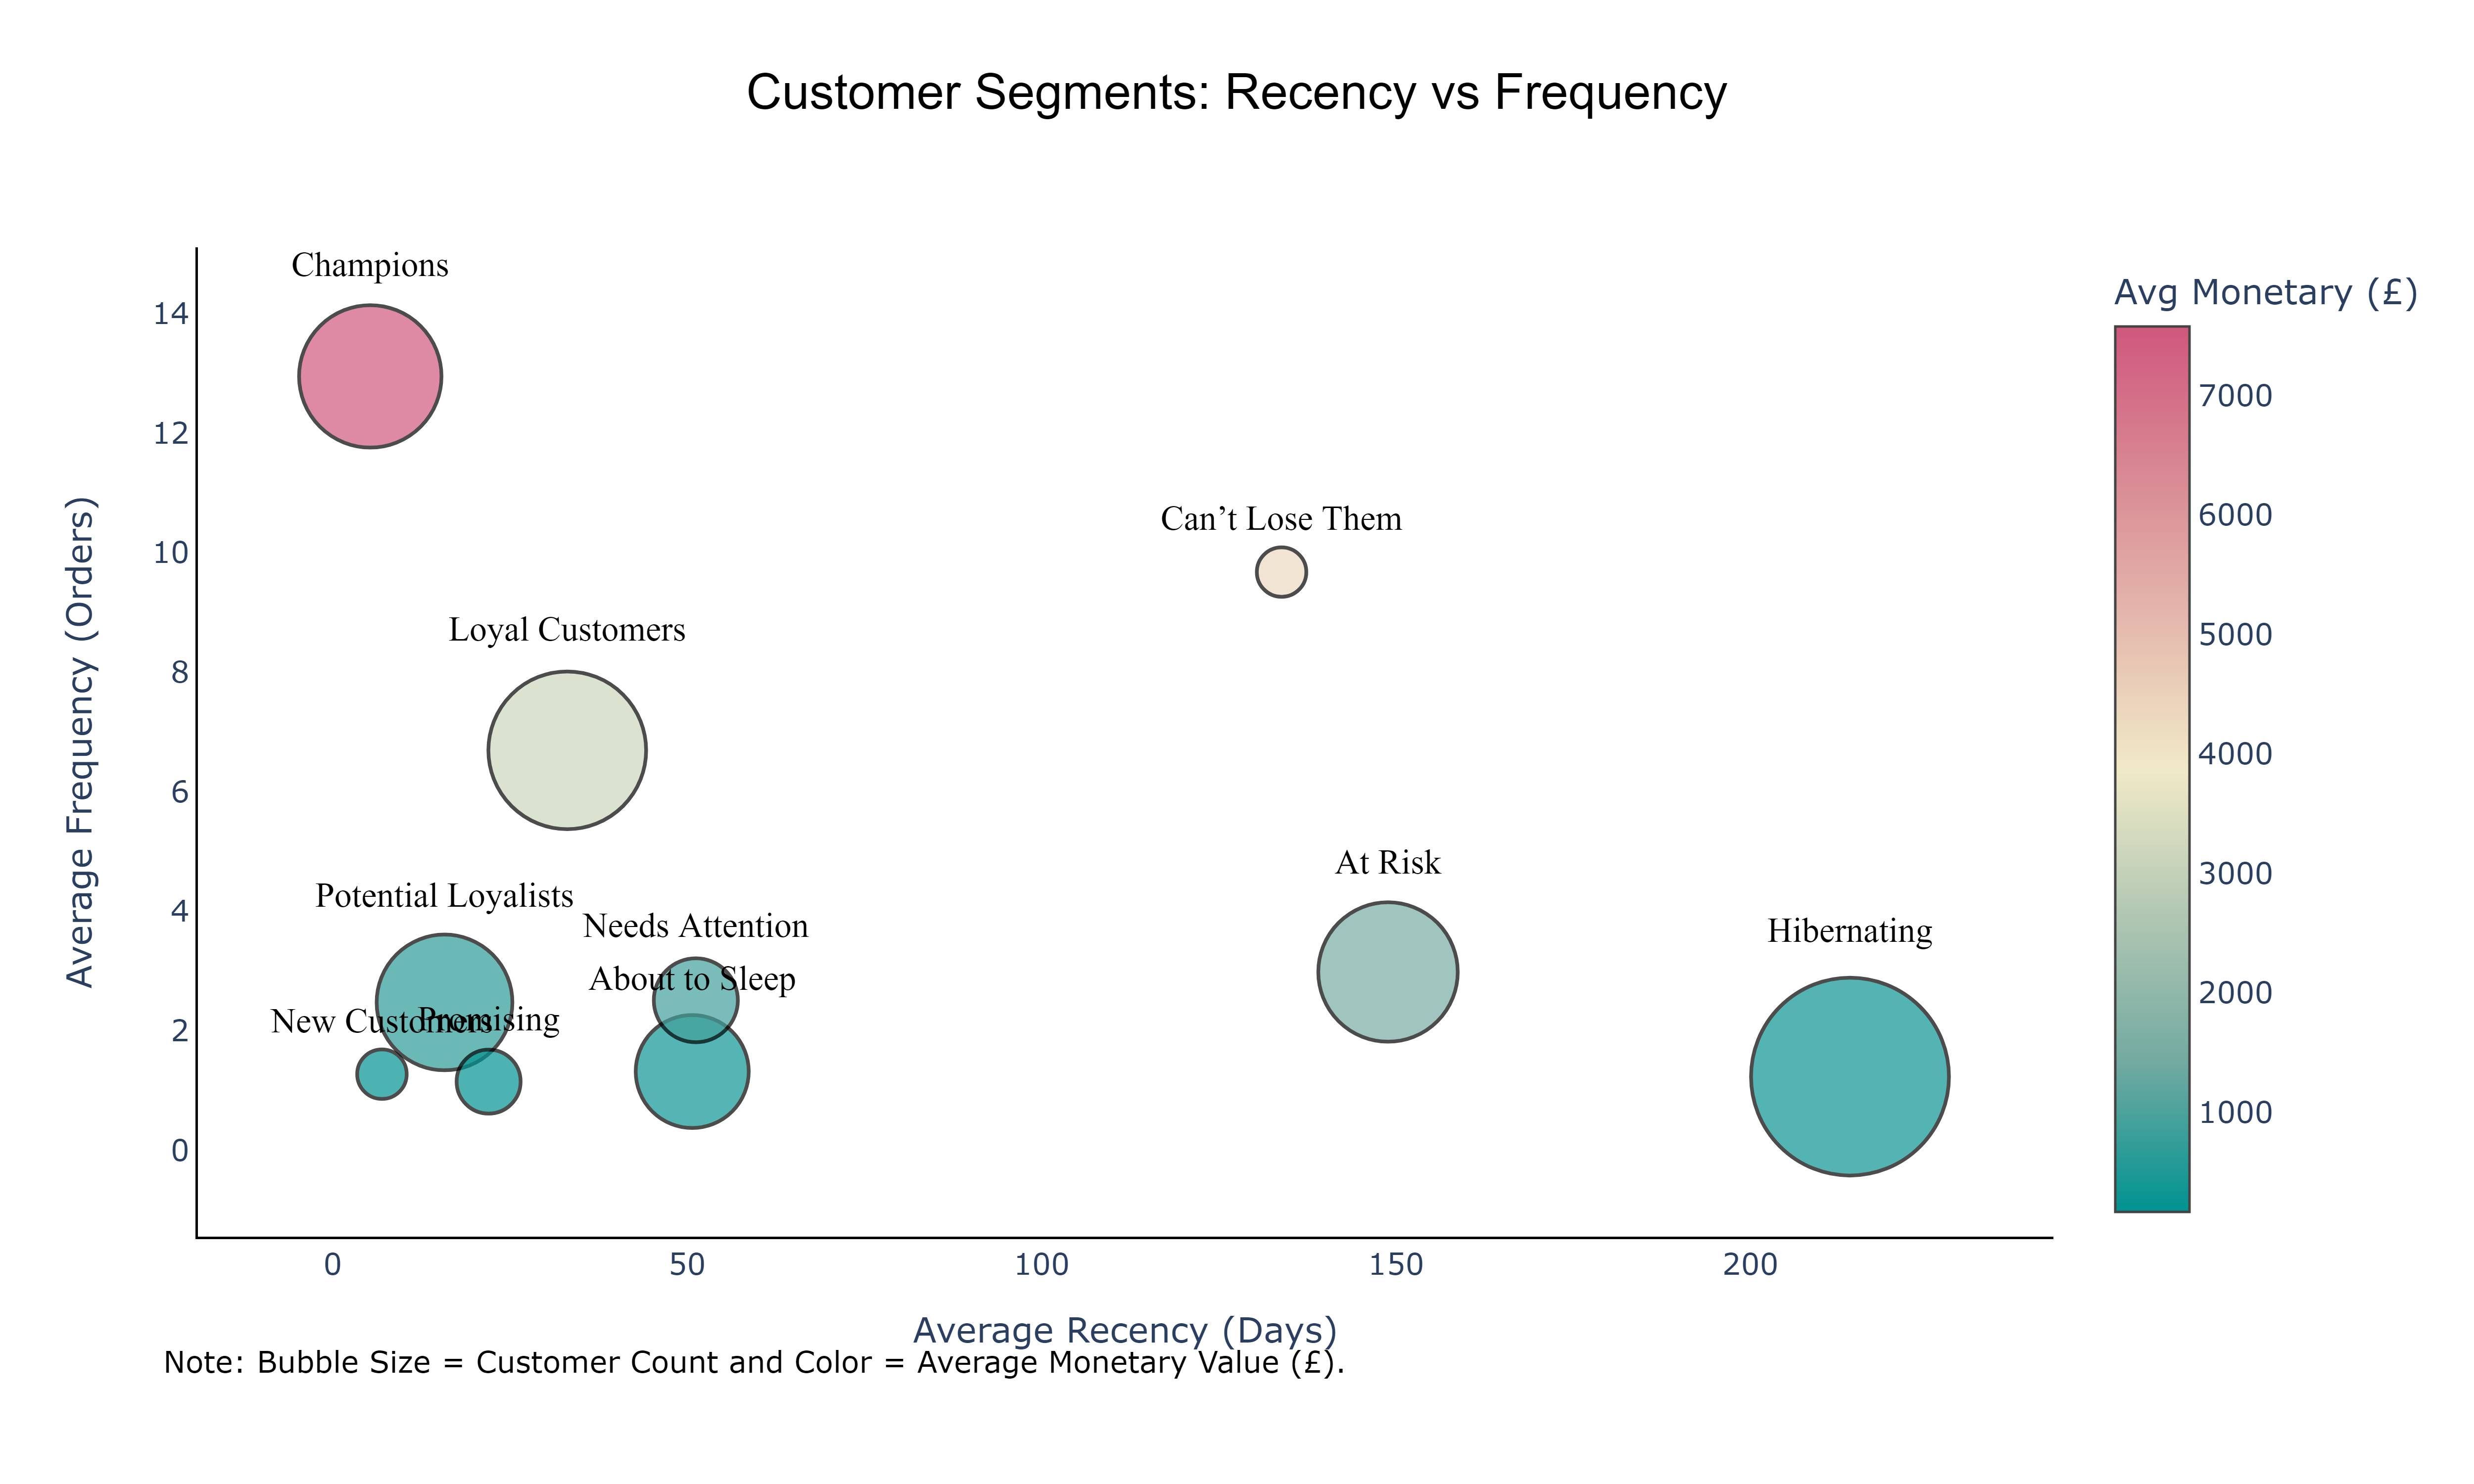

In [26]:
# Close the database connection
conn.close()

# Create figure
fig = go.Figure()

# Add scatter (bubble plot)
fig.add_trace(
    go.Scatter(x=df_order_segment["avg_recency"], y=df_order_segment["avg_frequency"], mode='markers+text', text=df_order_segment["customer_segment"], 
               textposition='top center', textfont=dict(family='Verdana Bold',   size=14, color='black'),
               marker=dict(size=df_order_segment["total_customers"], sizemode='area', sizeref=2.*max(df_order_segment["total_customers"])/(80**2),
                           sizemin=10, color=df_order_segment["avg_monetary"], colorscale='tealrose', colorbar=dict(title='Avg Monetary (£)'),
                           line=dict(width=1.5, color='black')),
               hovertemplate= "<b>%{text}</b><br><br>" + "Recency: %{x:.2f} days<br>" + "Frequency: %{y:.2f} orders<br>" +      
                              "Average Monetary: £%{marker.color:,.2f}<br>" + "Total Customers: %{marker.size:,}<extra></extra>",
              showlegend=False))
fig.update_layout(
    title={'text': 'Customer Segments: Recency vs Frequency', 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top',
           'font': dict(size=20, family='Arial', color='black')},
    annotations=[
        dict(text="Note: Bubble Size = Customer Count and Color = Average Monetary Value (£).", x=0.3, y=-0.15, xref='paper', yref='paper',
             showarrow=False, font=dict(size=12, color="black"), xanchor='center')],
    height=700, width=1000, margin=dict(b=100), plot_bgcolor='white', paper_bgcolor='white',
    xaxis=dict(title="Average Recency (Days)", showgrid=False, linecolor='black'),
    yaxis=dict(title="Average Frequency (Orders)", showgrid=False, linecolor='black'))
fig.show()

# Save as standalone HTML
pyo.plot(fig, filename="segment_bubble_chart.html", auto_open=False)
# Save static image of the figure
pio.write_image(fig, "segment_bubble_chart.png", format="png", width=1000, height=600, scale=5)
display(Image(filename="segment_bubble_chart.png"))

This bubble chart plots customer segments by their average **Recency (x-axis)** and **Frequency (y-axis)**:
- **Bubble size** represents the number of customers in each segment.
- **Bubble color** reflects the segment’s **average monetary value (£)**.

Key insights:
- **Champions** have low recency, high frequency, and top monetary value — placed in the ideal top-left of the chart.
- Segments like **Can’t Lose Them** and **At Risk** also show strong past activity but suffer from high recency, placing them in the recovery zone.
- **Hibernating** and **Promising** segments cluster in low-frequency and low-value regions — good targets for reactivation or onboarding strategies.

<a id="section3"></a>
## <span style="color: #0D47A1;">**Insights & Recommendations**</span>

---



### **Customer Segmentation Insights (From RFM Analysis)**

#### **1. Focus on High-Value Segments**
- **Insight:**  
  - **Champions (14%)** and **Loyal Customers (17%)** together generate over **£6.7M**, contributing nearly **80% of total revenue**.  
  - **Champions (589 customers)** alone drive over **£4.4M** — more than **50% of overall revenue**.  
  - These segments have **low recency**, **high frequency**, and **strong monetary value**, indicating deep brand engagement.  
  - **Loyal Customers** and **Potential Loyalists** (1,250+ customers) show **consistent and growing purchasing behavior**.

- **Recommendations:**  
  - Offer **VIP treatment** to Champions through **early access**, **exclusive rewards**, and **referral bonuses**.  
  - Use **personalized upselling** and **priority engagement** to deepen loyalty with top-tier customers.  
  - Convert Potential Loyalists into Loyal Customers using **tailored promotions**, **loyalty programs**, and **curated bundles**, while encouraging **reviews and referrals**.

#### **2. Recover At-Risk & Dormant High-Value Customers**
- **Insight:**  
  - Segments like **“Can’t Lose Them”** and **“At Risk”** have **high historical spending** but recent disengagement.  
  - Despite inactivity, they still contribute over **£1M in revenue**, showing strong **recovery potential**.

- **Recommendations:**  
  - Launch **win-back campaigns** with **personalized emails**, **exclusive discounts**, and **time-sensitive offers**.  
  - Use **VIP reactivation strategies** for “Can’t Lose Them,” and **automated re-engagement flows** for “At Risk,” showcasing **trending or previously viewed products**.

#### **3. Nurture Promising & New Customers**
- **Insight:**  
  - **New** and **Promising** customers show **high recency**, but **low frequency and spending**, indicating **early-stage engagement** with potential long-term value.

- **Recommendations:**  
  - Create **welcome journeys** with **onboarding guides**, **follow-up emails**, and **second-purchase incentives**.  
  - Offer **personalized product suggestions** and **small loyalty rewards** to build purchase habits.  
  - Encourage early enrollment in **loyalty programs** to guide Promising customers toward higher-value behaviors.

#### **4. Optimize or Let Go of Low-ROI Segments**
- **Insight:**  
  - Segments like **“About to Sleep”**, **“Needs Attention”**, and **“Hibernating”** include over **1,500 customers** but contribute **minimal revenue** and show **limited engagement**.

- **Recommendations:**  
  - Use **batch marketing** approaches such as **seasonal promos** or **“We miss you” emails**.  
  - Trigger **cart reminders** and **one-click reorder prompts** to re-engage low-ROI customers.  
  - **Avoid high-effort outreach** — focus instead on slide, report, or GitHub `README.md` format.